## Bayesian convolutional neural network

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

tfd = tfp.distributions
tfpl = tfp.layers

# If you would like to make further imports from tensorflow, add them here



![MNIST and MNIST-corrupted overview image](data/mnist_corrupted.png)

#### The MNIST and MNIST-C datasets

In this assignment, you will use the [MNIST](http://yann.lecun.com/exdb/mnist/) and [MNIST-C](https://github.com/google-research/mnist-c) datasets, which both consist of a training set of 60,000 handwritten digits with corresponding labels, and a test set of 10,000 images. The images have been normalised and centred. The MNIST-C dataset is a corrupted version of the MNIST dataset, to test out-of-distribution robustness of computer vision models.

- Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.
- N. Mu and J. Gilmeer. "MNIST-C: A Robustness Benchmark for Computer Vision" https://arxiv.org/abs/1906.02337

Your goal is to construct a neural network that classifies images of handwritten digits into one of 10 classes.

#### Load the datasets

We'll start by importing two datasets. The first is the MNIST dataset of handwritten digits, and the second is the MNIST-C dataset, which is a corrupted version of the MNIST dataset. This dataset is available on [TensorFlow datasets](https://www.tensorflow.org/datasets/catalog/mnist_corrupted). We'll be using the dataset with "spatters". We will load and inspect the datasets below. We'll use the notation `_c` to denote `corrupted`. The images are the same as in the original MNIST, but are "corrupted" by some grey spatters.

In [2]:
# Function to load training and testing data, with labels in integer and one-hot form

def load_data(name):
    data_dir = os.path.join('data', name)
    x_train = 1 - np.load(os.path.join(data_dir, 'x_train.npy')) / 255.
    x_train = x_train.astype(np.float32)
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    x_test  = 1 - np.load(os.path.join(data_dir, 'x_test.npy')) / 255.
    x_test = x_test.astype(np.float32)
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    y_test_oh = tf.keras.utils.to_categorical(y_test)
    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh)

In [3]:
# Function to inspect dataset digits

def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap='gray')
        ax[i].axis('off')
    plt.show()

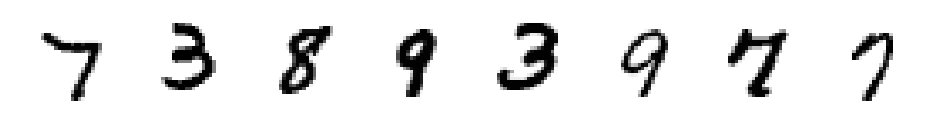

In [4]:
# Load and inspect the MNIST dataset

(x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh) = load_data('MNIST')
inspect_images(data=x_train, num_images=8)

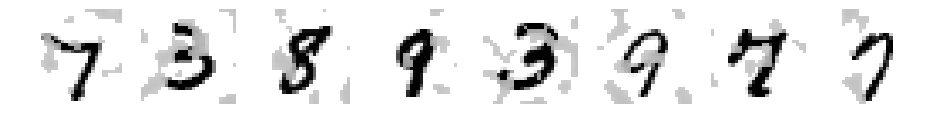

In [5]:
# Load and inspect the MNIST-C dataset

(x_c_train, y_c_train, y_c_train_oh), (x_c_test, y_c_test, y_c_test_oh) = load_data('MNIST_corrupted')
inspect_images(data=x_c_train, num_images=8)

#### Create the deterministic model

We will first train a standard deterministic CNN classifier model as a base model before implementing the probabilistic and Bayesian neural networks. You should now build the deterministic model using the Sequential API according to the following specifications:

* The first layer should be Conv2D layer with 8 filters, 5x5 kernel size, ReLU activation and `'VALID'` padding.
    * This layer should set the `input_shape` according to the function argument
* The second layer should be a MaxPooling2D layer with a 6x6 window size.
* The third layer should be a Flatten layer
* The final layer should be a Dense layer with 10 units and softmax activation

In total, the network should have 4 layers.

The model should then be compiled with the loss function, optimiser and list of metrics supplied in the function arguments.

In [10]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_deterministic_model(input_shape, loss, optimizer, metrics):
    """
    This function should build and compile a CNN model according to the above specification. 
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    model = Sequential([
        Conv2D(input_shape = input_shape,filters = 8,kernel_size = (5,5),activation = "relu",padding = "valid"),
        MaxPooling2D((6,6)),
        Flatten(),
        Dense(10,activation = "softmax")
    ])
    model.compile(loss = loss,optimizer = optimizer,metrics = metrics)
    return model
    
    

In [11]:
# Run your function to get the benchmark model

tf.random.set_seed(0)
deterministic_model = get_deterministic_model(
    input_shape=(28, 28, 1), 
    loss=SparseCategoricalCrossentropy(), 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

In [12]:
# Print the model summary

deterministic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the model
deterministic_model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.5030 - accuracy: 0.8644
Epoch 2/5
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.1557 - accuracy: 0.9528
Epoch 3/5
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.1215 - accuracy: 0.9628
Epoch 4/5
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.1058 - accuracy: 0.9678
Epoch 5/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0957 - accuracy: 0.9708


In [14]:
# Evaluate the model
print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(x_test, y_test, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(deterministic_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9729
Accuracy on corrupted MNIST test set:  0.9442


As you might expect, the pointwise performance on the corrupted MNIST set is worse. This makes sense, since this dataset is slightly different, and noisier, than the uncorrupted version. Furthermore, the model was trained on the uncorrupted MNIST data, so has no experience with the spatters.

### Probabilistic CNN model

You'll start by turning this deterministic network into a probabilistic one, by letting the model output a distribution instead of a deterministic tensor. This model will capture the aleatoric uncertainty on the image labels. You will do this by adding a probabilistic layer to the end of the model and training using the negative loglikelihood. 

You should first define the negative loss likelihood loss function below. This function has arguments `y_true` for the correct label (as a one-hot vector), and `y_pred` as the model prediction (a `OneHotCategorical` distribution). It should return the negative log-likelihood of each sample in `y_true` given the predicted distribution `y_pred`. If `y_true` is of shape `[B, E]` and `y_pred` has batch shape `[B]` and event shape `[E]`, the output should be a Tensor of shape `[B]`.

In [18]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def nll(y_true, y_pred):
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape 
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output 
    should be a Tensor of shape [B].
    """
    return -y_pred.log_prob(y_true)    

You should now build your probabilistic model according to the following specification:

* The first three layers are the same as for the deterministic model above
* The fourth layer should be a Dense layer with no activation function, and the correct number of units needed to parameterise the probabilistic layer that follows
* The final layer should be a probabilistic layer that outputs a `OneHotCategorical` distribution with an event shape of `[10]`, corresponding to the 10 digits
* The `convert_to_tensor_fn` in the categorical layer should be set to the mode

In total, your model should have 5 layers.

The model should then be compiled with the loss function, optimiser and list of metrics supplied in the function arguments.

In [24]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    """
    This function should return the probabilistic model according to the 
    above specification.
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    model = Sequential([
        Conv2D(input_shape = input_shape,filters = 8,kernel_size = (5,5),activation = "relu",padding = "valid"),
        MaxPooling2D((6,6)),
        Flatten(),
        Dense(tfpl.OneHotCategorical.params_size(10)),
        tfpl.OneHotCategorical(10,convert_to_tensor_fn = tfd.Distribution.sample)
    ])
    model.compile(loss = loss,optimizer = optimizer,metrics = metrics)
    return model
    
    

In [25]:
# Run your function to get the probabilistic model

tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(28, 28, 1), 
    loss=nll, 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

In [26]:
# Print the model summary
probabilistic_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 10), (None, 10))  0         
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


Now, you can train the probabilistic model on the MNIST data using the code below. 

Note that the target data now uses the one-hot version of the labels, instead of the sparse version. This is to match the categorical distribution you added at the end.

In [29]:
# Train the model
probabilistic_model.fit(x_train, y_train_oh, epochs=1)

Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.0892 - accuracy: 0.9576
Epoch 2/2
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.0843 - accuracy: 0.9591


In [28]:
# Evaluate the model
print('Accuracy on MNIST test set: ',
      str(probabilistic_model.evaluate(x_test, y_test_oh, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(probabilistic_model.evaluate(x_c_test, y_c_test_oh, verbose=False)[1]))

Accuracy on MNIST test set:  0.9581
Accuracy on corrupted MNIST test set:  0.9186


Note that the test accuracy of the probabilistic model is identical to the deterministic model. This is because the model architectures for both are equivalent; the only difference being that the probabilistic model returns a distribution object. Since we have also set the same random seed for both models, the trained variables are in fact identical, as the following cell shows.

In [30]:
# Check all the weights of the deterministic and probabilistic models are identical

for deterministic_variable, probabilistic_variable in zip(deterministic_model.weights, probabilistic_model.weights):
    print(np.allclose(deterministic_variable.numpy(), probabilistic_variable.numpy()))

False
False
False
False


#### Analyse the model predictions

We will now do some deeper analysis by looking at the probabilities the model assigns to each class instead of its single prediction. 

The function below will be useful to help us analyse the probabilistic model predictions.

In [31]:
# Function to make plots of the probabilities that the model estimates for an image

def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

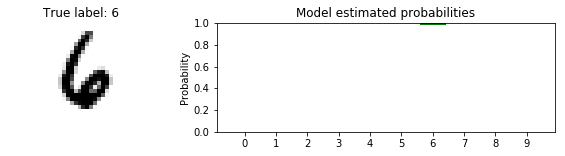

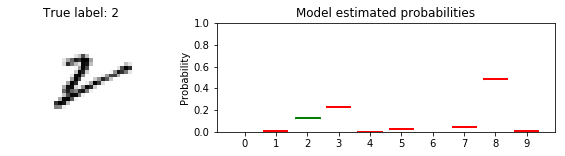

In [32]:
# Prediction examples on MNIST

for i in [0, 1577]:
    analyse_model_prediction(x_test, y_test, probabilistic_model, i)

The model is very confident that the first image is a 6, which is correct. For the second image, the model struggles, assigning nonzero probabilities to many different classes. 

Run the code below to do the same for 2 images from the corrupted MNIST test set.

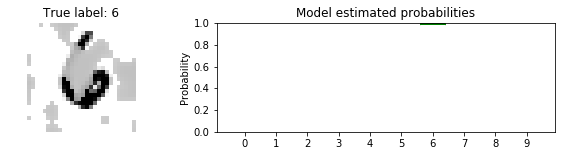

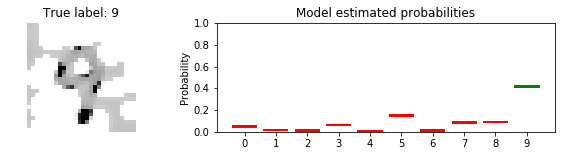

In [33]:
# Prediction examples on MNIST-C

for i in [0, 3710]:
    analyse_model_prediction(x_c_test, y_c_test, probabilistic_model, i)

The first is the same 6 as you saw above, but the second image is different. Notice how the model can still say with high certainty that the first image is a 6, but struggles for the second, assigning an almost uniform distribution to all possible labels.

Finally, have a look at an image for which the model is very sure on MNIST data but very unsure on corrupted MNIST data:

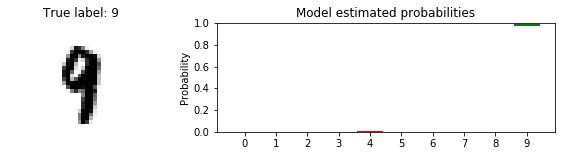

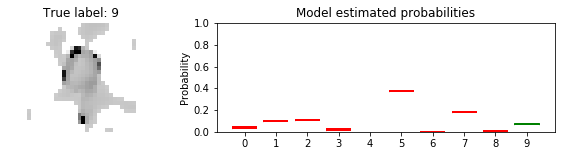

In [34]:
# Prediction examples from both datasets
for i in [9241]:
    analyse_model_prediction(x_test, y_test, probabilistic_model, i)
    analyse_model_prediction(x_c_test, y_c_test, probabilistic_model, i)

It's not surprising what's happening here: the spatters cover up most of the number. You would hope a model indicates that it's unsure here, since there's very little information to go by. This is exactly what's happened.

#### Uncertainty quantification using entropy

We can also make some analysis of the model's uncertainty across the full test set, instead of for individual values. One way to do this is to calculate the [entropy](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29) of the distribution. The entropy is the expected information (or informally, the expected 'surprise') of a random variable, and is a measure of the uncertainty of the random variable. The entropy of the estimated probabilities for sample $i$ is defined as

$$
H_i = -\sum_{j=1}^{10} p_{ij} \text{log}_{2}(p_{ij})
$$

where $p_{ij}$ is the probability that the model assigns to sample $i$ corresponding to label $j$. The entropy as above is measured in _bits_. If the natural logarithm is used instead, the entropy is measured in _nats_.

The key point is that the higher the value, the more unsure the model is. Let's see the distribution of the entropy of the model's predictions across the MNIST and corrupted MNIST test sets. The plots will be split between predictions the model gets correct and incorrect.

In [35]:
# Functions to plot the distribution of the information entropy across samples,
# split into whether the model prediction is correct or incorrect


def get_correct_indices(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    probs = model(x).mean().numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

MNIST test set:


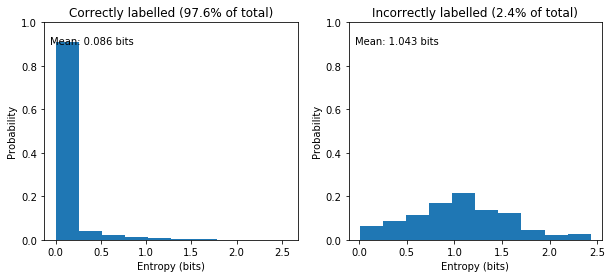

In [36]:
# Entropy plots for the MNIST dataset
print('MNIST test set:')
plot_entropy_distribution(probabilistic_model, x_test, y_test)

Corrupted MNIST test set:


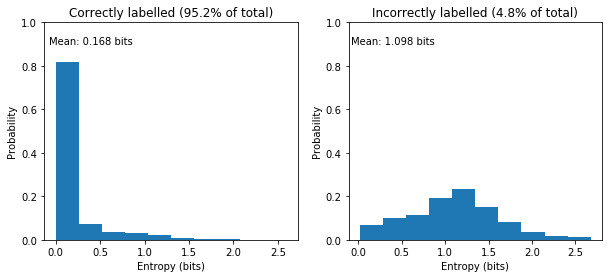

In [37]:
# Entropy plots for the MNIST-C dataset
print('Corrupted MNIST test set:')
plot_entropy_distribution(probabilistic_model, x_c_test, y_c_test)

There are two main conclusions:
- The model is more unsure on the predictions it got wrong: this means it "knows" when the prediction may be wrong.
- The model is more unsure for the corrupted MNIST test than for the uncorrupted version. Futhermore, this is more pronounced for correct predictions than for those it labels incorrectly.

In this way, the model seems to "know" when it is unsure. This is a great property to have in a machine learning model, and is one of the advantages of probabilistic modelling.

### Bayesian CNN model

The probabilistic model you just created considered only aleatoric uncertainty, assigning probabilities to each image instead of deterministic labels. The model still had deterministic weights. However, as you've seen, there is also 'epistemic' uncertainty over the weights, due to uncertainty about the parameters that explain the training data. 

You'll now be adding weight uncertainty to the model you just created. Your new model will again have the following layers:
- 2D convolution
- Max pooling
- Flatten
- Dense
- OneHotCategorical

but where the convolutional and dense layers include weight uncertainty. You'll embed weight uncertainty as follows:
- The 2D convolution layer will be replaced by a `Convolution2DReparameterization` layer
- The Dense layer will be replaced by a `DenseVariational` layer.

You should start by creating the convolutional layer in the function below. The function should return an instance of the `Convolution2DReparameterization` layer, according to the following specification: 

* The function takes the `input_shape` and `divergence_fn` as arguments
* The layer should set the input shape in its constructor using the `input_shape` argument
* This layer should have 8 filters, a kernel size of `(5, 5)`, a ReLU activation, and `"VALID"` padding
* The prior for both the kernel and bias should be the standard `default_multivariate_normal_fn`, as seen in the coding tutorial
* The posterior for each parameter in both the kernel and bias should be an independent normal distribution with trainable mean and variance (_hint: use the_ `default_mean_field_normal_fn`_)_
* The divergence function should be set using the `divergence_fn` argument for both the kernel and the bias

_HINT: Review the arguments you used in the coding tutorial on Reparameterization layers._

In [ ]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_convolutional_reparameterization_layer(input_shape, divergence_fn):
    """
    This function should create an instance of a Convolution2DReparameterization 
    layer according to the above specification. 
    The function takes the input_shape and divergence_fn as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    conv_layer = tfpl.Convolution2DReparameterization(filters = 8,
                                                      input_shape = input_shape,
                                                      kernel_size = (5,5),
                                                      kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                                      kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
                                                      kernel_divergence_fn = divergence_fn,
                                                      bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                                      bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
                                                      bias_divergence_fn = divergence_fn,
                                                      activation= "relu")
    return conv_layer
                                                        
    
    

You'll use this function to create your model a little bit later on. 

#### Custom prior

For the parameters of the `DenseVariational` layer, we will use a custom prior: the "spike and slab" (also called a *scale mixture prior*) distribution. This distribution has a density that is the weighted sum of two normally distributed ones: one with a standard deviation of 1 and one with a standard deviation of 10. In this way, it has a sharp spike around 0 (from the normal distribution with standard deviation 1), but is also more spread out towards far away values (from the contribution from the normal distribution with standard deviation 10). The reason for using such a prior is that it is like a standard unit normal, but makes values far away from 0 more likely, allowing the model to explore a larger weight space. Run the code below to create a "spike and slab" distribution and plot its probability density function, compared with a standard unit normal.

In [42]:
# Function to define the spike and slab distribution

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

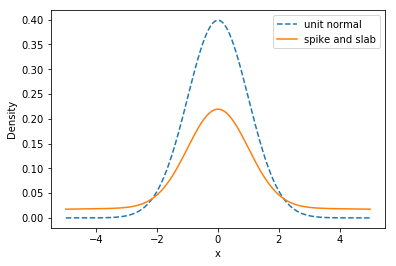

In [43]:
# Plot the spike and slab distribution pdf

x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

You should now complete the function below to create the prior distribution for the `DenseVariational` layer, using the spike and slab distribution above.

* The function has the required signature for the `make_prior_fn` argument of the `DenseVariational` layer
* The prior will have no trainable parameters
* It should use the spike and slab distribution for both the kernel and the bias, setting the `dtype` according to the function argument
* The distribution should have the correct event shape, according to the `kernel_size` and `bias_size` arguments
* The function should return a callable, that returns the spike and slab distribution

_Hints:_ 
* _Refer to the lecture video and/or coding tutorial to review the_ `DenseVariational` _layer arguments_
* _Use the_ `Sequential` _API with a_ `DistributionLambda` _layer to create the callable that is returned by the function_

In [44]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_prior(kernel_size, bias_size, dtype=None):
    """
    This function should create the prior distribution, consisting of the 
    "spike and slab" distribution that is described above. 
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the prior distribution.
    """
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc= tf.zeros(n),scale_diag = tf.ones(n)))
    ])
    return prior_model
    
    

You'll use this function when you create the `DenseVariational` layer later on.

You should now complete the function below to create the variational posterior distribution for the `DenseVariational` layer. This distribution will be an independent Gaussian with trainable mean and standard deviation for each parameter in the layer.

* The function has the required signature for the `make_posterior_fn` argument of the `DenseVariational` layer
* The posterior will have 2 trainable variables for each layer parameter, one for the mean and one for the standard deviation
* The distribution should have the correct event shape, according to the `kernel_size` and `bias_size` arguments
* The function should return a callable, that returns the trainable independent Gaussian distribution

_Hints:_ 
* _Refer to the lecture video and/or coding tutorial to review the_ `DenseVariational` _layer arguments_
* _Use the_ `Sequential` _API with a_ `VariableLayer` and an `IndependentNormal` _layer to create the callable that is returned by the function_

In [49]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_posterior(kernel_size, bias_size, dtype=None):
    """
    This function should create the posterior distribution as specified above.
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the posterior distribution.
    """
    n = kernel_size +bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n),dtype = dtype),
        tfpl.IndependentNormal(n)
    ])
    return posterior_model
    

You should now use your `prior` and `posterior` functions to complete the function below to create the `DenseVariational` layer. 

* The function has `prior_fn`, `posterior_fn` and `kl_weight` arguments, to be used in the constructor of the `DenseVariational` layer
* The layer should have the correct number of units in order to parameterize a `OneHotCategorical` layer with 10 categories
* The `make_prior_fn`, `make_posterior_fn` and `kl_weight` arguments should be set with the corresponding function arguments
* An exact KL-divergence is unavailable for this choice of prior and posterior, so the layer should not attempt to use an analytical expression for this
* Your function should then return an instance of the `DenseVariational` layer

In [54]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_dense_variational_layer(prior_fn, posterior_fn, kl_weight):
    """
    This function should create an instance of a DenseVariational layer according 
    to the above specification. 
    The function takes the prior_fn, posterior_fn and kl_weight as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    dense_layer = tfpl.DenseVariational(tfpl.OneHotCategorical.params_size(10),
                                   make_prior_fn = prior_fn,
                                   make_posterior_fn = posterior_fn,
                                   kl_weight = kl_weight)
    return dense_layer

Now, you're ready to use the functions you defined to create the convolutional reparameterization and dense variational layers, and use them in your Bayesian convolutional neural network model.

In [55]:
# Create the layers

tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]
convolutional_reparameterization_layer = get_convolutional_reparameterization_layer(
    input_shape=(28, 28, 1), divergence_fn=divergence_fn
)
dense_variational_layer = get_dense_variational_layer(
    get_prior, get_posterior, kl_weight=1/x_train.shape[0]
)

In [56]:
# Build and compile the Bayesian CNN model

bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])
bayesian_model.compile(loss=nll,
              optimizer=RMSprop(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [57]:
# Print the model summary
bayesian_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_4  (None, 24, 24, 8)         416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_variational (DenseVari (None, 10)                833985    
_________________________________________________________________
one_hot_categorical_2 (OneHo ((None, 10), (None, 10))  0         
Total params: 834,401
Trainable params: 834,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
bayesian_model.fit(x=x_train, y=y_train_oh, epochs=10, verbose=True)

Train on 60000 samples
Epoch 1/10
 9152/60000 [===>..........................] - ETA: 4:56 - loss: 1.6561 - accuracy: 0.6897

In [ ]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(bayesian_model.evaluate(x_test, y_test_oh, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(bayesian_model.evaluate(x_c_test, y_c_test_oh, verbose=False)[1]))

#### Analyse the model predictions

Now that the model has trained, run the code below to create the same plots as before, starting with an analysis of the predicted probabilities for the same images. 

This model now has weight uncertainty, so running the forward pass multiple times will not generate the same estimated probabilities. For this reason, the estimated probabilities do not have single values. The plots are adjusted to show a 95% prediction interval for the model's estimated probabilities.

In [ ]:
# Prediction examples on MNIST

for i in [0, 1577]:
    analyse_model_prediction(x_test, y_test, bayesian_model, i, run_ensemble=True)

For the first image, the model assigns a probability of almost one for the 6 label. Furthermore, it is confident in this probability: this probability remains close to one for every sample from the posterior weight distribution (as seen by the horizontal green line having very small height, indicating a narrow prediction interval). This means that the epistemic uncertainty on this probability is very low. 

For the second image, the epistemic uncertainty on the probabilities is much larger, which indicates that the estimated probabilities may be unreliable. In this way, the model indicates whether estimates may be inaccurate.

In [ ]:
# Prediction examples on MNIST-C

for i in [0, 3710]:
    analyse_model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

Even with the spatters, the Bayesian model is confident in predicting the correct label for the first image above. The model struggles with the second image, which is reflected in the range of probabilities output by the network.

In [ ]:
# Prediction examples from both datasets

for i in [9241]:
    analyse_model_prediction(x_test, y_test, bayesian_model, i, run_ensemble=True)
    analyse_model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

Similar to before, the model struggles with the second number, as it is mostly covered up by the spatters. However, this time is clear to see the epistemic uncertainty in the model.

#### Uncertainty quantification using entropy

We also again plot the distribution of distribution entropy across the different test sets below. In these plots, no consideration has been made for the epistemic uncertainty, and the conclusions are broadly similar to those for the previous model.

In [ ]:
# Entropy plots for the MNIST dataset

print('MNIST test set:')
plot_entropy_distribution(bayesian_model, x_test, y_test)

In [ ]:
# Entropy plots for the MNIST-C dataset

print('Corrupted MNIST test set:')
plot_entropy_distribution(bayesian_model, x_c_test, y_c_test)